In [1]:
# !pip uninstall shapely -y
# !pip uninstall shapely -y
# !pip install shapely
# !pip install contextily==1.1.0

In [2]:
import preprocessing_utils as p
import stgcn
import analysis as a
import visualisation as v
import speedband_dataset as d
import model_utils as m

from pathlib import Path
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

# Settings

In [3]:
data_dir = Path("/home/jovyan/shared_datasets/traffic_speed_bands/downtown/processed")

# From training set
means = [4.43166567, 2.55106077, 0.08281905, 4.0460931, 11.53766421]
stds = [1.6744557, 1.55828848, 0.04885751, 1.98377927, 6.93358581]

features = [0,1,2,3,4]

train_dataset = d.SpeedbandDataset(data_dir / "dataset" / "train", means, stds, features=features)
val_dataset = d.SpeedbandDataset(data_dir / "dataset" / "val", means, stds, features=features)
test_dataset = d.SpeedbandDataset(data_dir / "dataset" / "test", means, stds, features=features)
test_target_timestamps = np.load(data_dir / "dataset" / "test" / "output_timestamps.npy", allow_pickle=True)

A_u, A_d, metadata, cat2index, timestamps = p.load_metadata(data_dir)

num_timesteps_input = train_dataset.num_timesteps_input # 60 minutes
num_timesteps_output = train_dataset.num_timesteps_output # 30 minutes
num_features = train_dataset.num_features
num_nodes = train_dataset.num_nodes
loss_weights = [32,16,8,4,2,1]
directed = False

directed_string = "directed" if directed else "undirected"
loss_weights_string = "".join([str(i) for i in loss_weights])
features_string = "".join([str(i) for i in features])
model_name = "downtown{}in{}out{}_{}_{}".format(num_timesteps_input, num_timesteps_output, loss_weights_string, directed_string, features_string)
model_path = "./saved_models/{}.pt".format(model_name)
preds_path = "./saved_predictions/{}_preds.npy".format(model_name)
actuals_path = "./saved_predictions/actuals.npy"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)

epochs = 500
batch_size = 32
lr = 0.001
patience = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

In [4]:
adj_mat = p.get_hybrid_combined_normalized_adj(A_d) if directed else p.get_symmetric_normalized_adj(A_u)
adj_mat = torch.from_numpy(adj_mat).float()

model = stgcn.STGCN(num_nodes, num_features, num_timesteps_input, num_timesteps_output)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = m.weighted_MSELoss(loss_weights, device=device)

# Training

In [5]:
# m.train(adj_mat, train_loader, val_loader, model, optimizer, criterion, patience, epochs, device)

In [6]:
# m.save_model(model, model_path)

# Analysis

In [7]:
m.load_model(model, model_path)
# m.validate(adj_mat, val_loader, model, criterion, device)

In [8]:
# pred, actual = m.predict(adj_mat, test_loader, model, means, stds, device)
# np.save(preds_path, pred)
# np.save(actuals_path, actual)

In [9]:
pred = np.load(preds_path)
actual = np.load(actuals_path)

## Best and Worst Roads

In [10]:
rmses = a.rmse_per_link(pred, actual)
mses = np.array(rmses) ** 2
rmse_by_timestep = np.mean(mses, 0) ** 0.5
print(rmse_by_timestep)

rmse_by_link = np.mean(mses, 1) ** 0.5
best_road = np.argmin(rmse_by_link)
worst_road = np.argmax(rmse_by_link)

[0.79023618 0.98734825 1.09328352 1.14920245 1.17745333 1.19597952]


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


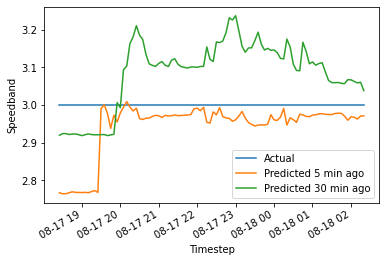

0.13486159815493662

In [11]:
a.plot_pred_actual(pred, actual, best_road, [0,5], test_target_timestamps, (200, 296))
rmse_by_link[best_road]

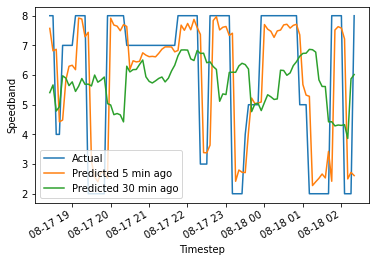

2.38458031522253

In [12]:
a.plot_pred_actual(pred, actual, worst_road, [0,5], test_target_timestamps, (200, 296))
rmse_by_link[worst_road]

## Performance by Time

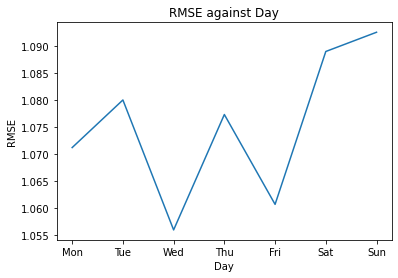

In [13]:
day_rmse, _ = a.rmse_per_time(pred, actual, test_target_timestamps, timeidx=0)
day_rmse = OrderedDict([("Mon", day_rmse["Mon"]),
                        ("Tue", day_rmse["Tue"]),
                        ("Wed", day_rmse["Wed"]),
                        ("Thu", day_rmse["Thu"]),
                        ("Fri", day_rmse["Fri"]),
                        ("Sat", day_rmse["Sat"]),
                        ("Sun", day_rmse["Sun"]),
                       ])
a.plot_rmse(day_rmse, xlabel='Day')

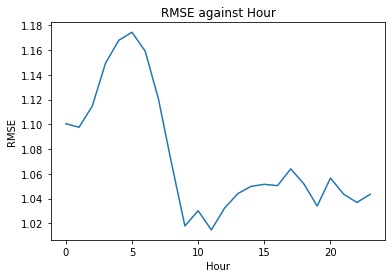

In [14]:
hour_rmse, _ = a.rmse_per_time(pred, actual, test_target_timestamps, timeidx=4)
hour_rmse = OrderedDict(sorted(hour_rmse.items()))
a.plot_rmse(hour_rmse, xlabel='Hour')

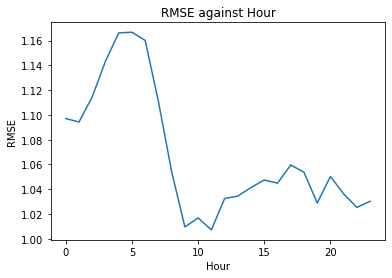

In [15]:
weekday_subpopulation = {0:set(["Mon", "Tue", "Wed", "Thu", "Fri"])}
hour_rmse_weekdays, _ = a.rmse_per_time(pred, actual, test_target_timestamps, timeidx=4, subpopulation = weekday_subpopulation)
hour_rmse_weekdays = OrderedDict(sorted(hour_rmse_weekdays.items()))
a.plot_rmse(hour_rmse_weekdays, xlabel='Hour')

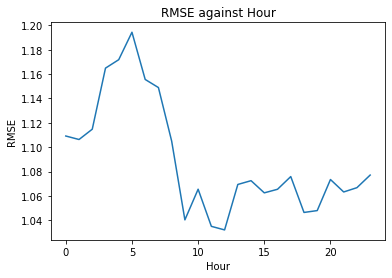

In [16]:
weekend_subpopulation = {0:set(["Sat", "Sun"])}
hour_rmse_weekends, _ = a.rmse_per_time(pred, actual, test_target_timestamps, timeidx=4, subpopulation = weekend_subpopulation)
hour_rmse_weekends = OrderedDict(sorted(hour_rmse_weekends.items()))
a.plot_rmse(hour_rmse_weekends, xlabel='Hour')

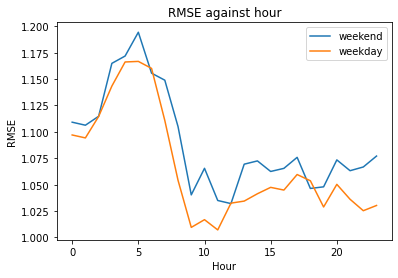

In [20]:
fig, ax = plt.subplots()
weekdays = []
weekends = []
x = []
for k in hour_rmse_weekdays.keys():
    weekdays.append(hour_rmse_weekdays[k])
    weekends.append(hour_rmse_weekends[k])
    x.append(k)
ax.plot(x, weekends, label = "weekend")
ax.plot(x, weekdays, label = "weekday")
ax.legend()
ax.set_ylabel("RMSE")
ax.set_xlabel("Hour")
ax.set_title("RMSE against hour")
plt.show()

## Performance by Geographical Properties

/opt/conda/lib/python3.6/site-packages/geopandas/plotting.py:183: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  segments = [np.array(linestring)[:, :2] for linestring in geoms]


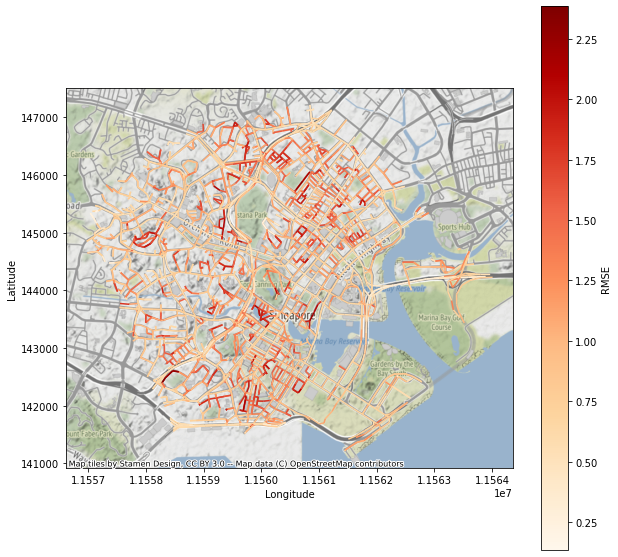

In [18]:
a.plot_geo_performance(metadata, rmse_by_link)

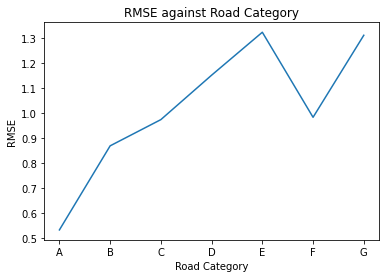

In [19]:
rmse_per_cat, cat_count = a.rmse_per_category(metadata, rmse_by_link)
rmse_per_cat = OrderedDict(sorted(rmse_per_cat.items()))
a.plot_rmse(rmse_per_cat, xlabel="Road Category")